# 캐글 폐렴 이미지 분류 및 예측
## https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
# 이미지 경로
train_normal    = glob.glob('D:/prac/chest_xray/train/NORMAL/*.jpeg')
train_pneumonia = glob.glob('D:/prac/chest_xray/train/PNEUMONIA/*.jpeg')
test_normal     = glob.glob('D:/prac/chest_xray/test/NORMAL/*.jpeg')
test_pneumonia  = glob.glob('D:/prac/chest_xray/test/PNEUMONIA/*.jpeg')
val_normal      = glob.glob('D:/prac/chest_xray/val/NORMAL/*.jpeg')
val_pneumonia   = glob.glob('D:/prac/chest_xray/val/PNEUMONIA/*.jpeg')

In [56]:
# 경로 \\ -> / 로 바꿈
train_normal = [x.replace('\\', '/') for x in train_normal]
train_pneumonia = [x.replace('\\', '/') for x in train_pneumonia]
test_normal = [x.replace('\\', '/') for x in test_normal]
test_pneumonia = [x.replace('\\', '/') for x in test_pneumonia]
val_normal = [x.replace('\\', '/') for x in val_normal]
val_pneumonia = [x.replace('\\', '/') for x in val_pneumonia]

In [57]:
# 이미지 라벨링
train_list = []
test_list = []
val_list = []

for x in train_normal:
    train_list.append([x, 0])
    
for x in train_pneumonia:
    train_list.append([x, 1])
    
for x in test_normal:
    test_list.append([x, 0])
    
for x in test_pneumonia:
    test_list.append([x, 1])
    
for x in val_normal:
    val_list.append([x, 0])
    
for x in val_pneumonia:
    val_list.append([x, 1])

In [58]:
train_list

[['D:/prac/chest_xray/train/NORMAL/IM-0115-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0117-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0119-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0122-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0125-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0127-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0128-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0129-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0131-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0133-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0135-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0137-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0140-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0141-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0143-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0145-0001.jpeg', 0],
 ['D:/prac/chest_xray/train/NORMAL/IM-0147-0001.jpeg', 0

In [59]:
# 데이터 프레임 생성
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

In [60]:
train_df

,image,label
0,D:/prac/chest_xray/train/NORMAL/IM-0115-0001.jpeg,0
1,D:/prac/chest_xray/train/NORMAL/IM-0117-0001.jpeg,0
2,D:/prac/chest_xray/train/NORMAL/IM-0119-0001.jpeg,0
3,D:/prac/chest_xray/train/NORMAL/IM-0122-0001.jpeg,0
4,D:/prac/chest_xray/train/NORMAL/IM-0125-0001.jpeg,0
...,...,...
5211,D:/prac/chest_xray/train/PNEUMONIA/person99_vi...,1
5212,D:/prac/chest_xray/train/PNEUMONIA/person9_bac...,1
5213,D:/prac/chest_xray/train/PNEUMONIA/person9_bac...,1
5214,D:/prac/chest_xray/train/PNEUMONIA/person9_bac...,1


In [61]:
import warnings
warnings.filterwarnings('ignore')

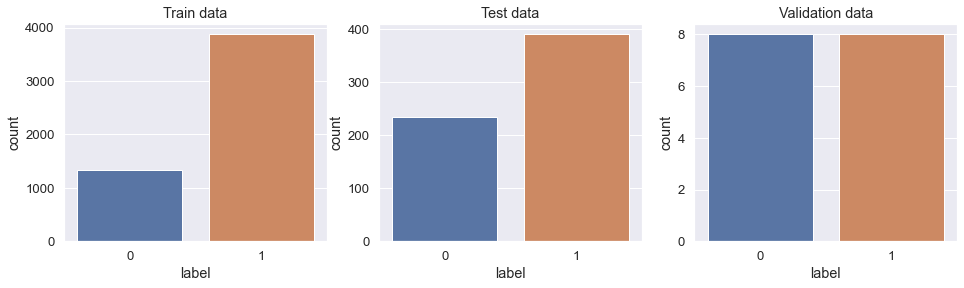

In [62]:
# 데이터 개수 시각화
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

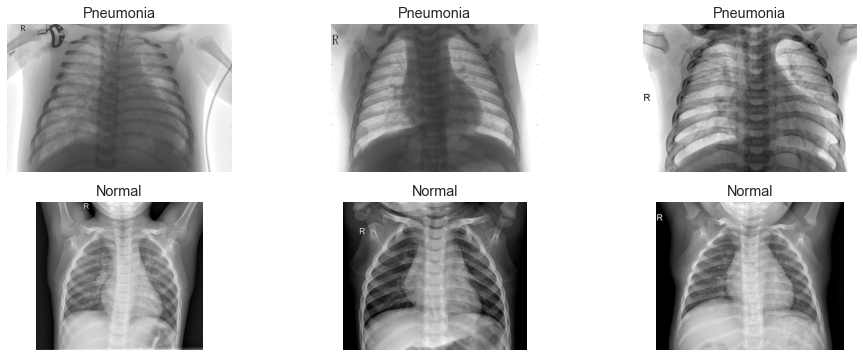

In [63]:
# 폐렴, 정상 이미지 시각화
plt.figure(figsize=(16,6))
for i,img_path in enumerate(train_df[train_df['label'] == 1][:3]['image']):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray_r')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][:3]['image']):
    plt.subplot(2,3,i+4)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

In [64]:
def preprocessing(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))
    
    return img

def make_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(preprocessing(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [65]:
# train, test 분리
X_train, y_train = make_dataset(train_df)
X_test, y_test = make_dataset(test_df)
X_val, y_val = make_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [66]:
X_val

array([[[[0.01568627],
         [0.01176471],
         [0.0627451 ],
         ...,
         [0.30196078],
         [0.28235294],
         [0.25098039]],

        [[0.00392157],
         [0.        ],
         [0.05098039],
         ...,
         [0.30588235],
         [0.27058824],
         [0.22352941]],

        [[0.01176471],
         [0.03921569],
         [0.04705882],
         ...,
         [0.28627451],
         [0.27058824],
         [0.24705882]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.01176471],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.81176471],
         [0.01176471],
         [0.48

In [67]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [68]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

In [69]:
datagen.fit(X_train, y_train)

In [70]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [71]:
model = Sequential()
model.add(Conv2D(16, (5,5), padding='same', activation='relu', input_shape=(196,196,1)))
model.add(Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 196, 196, 16)      416       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 196, 196, 16)      6416      
_________________________________________________________________
batch_normalization_24 (Batc (None, 196, 196, 16)      64        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 98, 98, 32)        12832     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 98, 98, 32)        25632     
_________________________________________________________________
batch_normalization_25 (Batc (None, 98, 98, 32)       

In [72]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

In [73]:
es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1,mode='max')
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor= 0.1, min_delta=0.01, min_lr=0.0001)
mc = ModelCheckpoint(filepath="chest_xray.h5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
with tensorflow.device('/gpu:0'):
    history = model.fit(
        datagen.flow(X_train,y_train, batch_size=16), 
        validation_data=(X_test, y_test), 
        epochs = 100, 
        verbose = 1, 
        callbacks=[es,lr_schedule, mc], 
        class_weight={0:6.0, 
                      1:0.5})

Epoch 1/100
326/326 [==============================] - 16s 47ms/step - loss: 0.6923 - accuracy: 0.6748 - val_loss: 0.4144 - val_accuracy: 0.7837
Epoch 2/100
326/326 [==============================] - 15s 45ms/step - loss: 0.3589 - accuracy: 0.8008 - val_loss: 0.7298 - val_accuracy: 0.7596
Epoch 3/100
326/326 [==============================] - 15s 45ms/step - loss: 0.2974 - accuracy: 0.8438 - val_loss: 2.6329 - val_accuracy: 0.3894
Epoch 4/100
326/326 [==============================] - 15s 45ms/step - loss: 0.2831 - accuracy: 0.8618 - val_loss: 0.8599 - val_accuracy: 0.7115
Epoch 5/100
326/326 [==============================] - 15s 45ms/step - loss: 0.2614 - accuracy: 0.8633 - val_loss: 0.2900 - val_accuracy: 0.8766
Epoch 6/100
326/326 [==============================] - 15s 45ms/step - loss: 0.2411 - accuracy: 0.8740 - val_loss: 0.3649 - val_accuracy: 0.8462
Epoch 7/100
326/326 [==============================] - 15s 46ms/step - loss: 0.2376 - accuracy: 0.8775 - val_loss: 0.2698 - val_ac

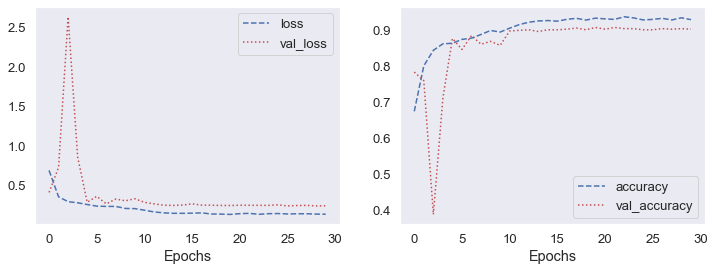

In [74]:
#모델 학습 결과 그래프 표시
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r:', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [75]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

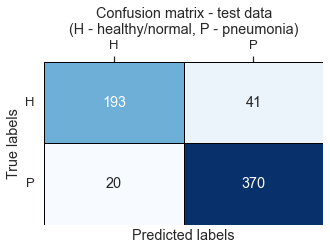

Classification report on test data
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       234
           1       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



In [76]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

In [77]:
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

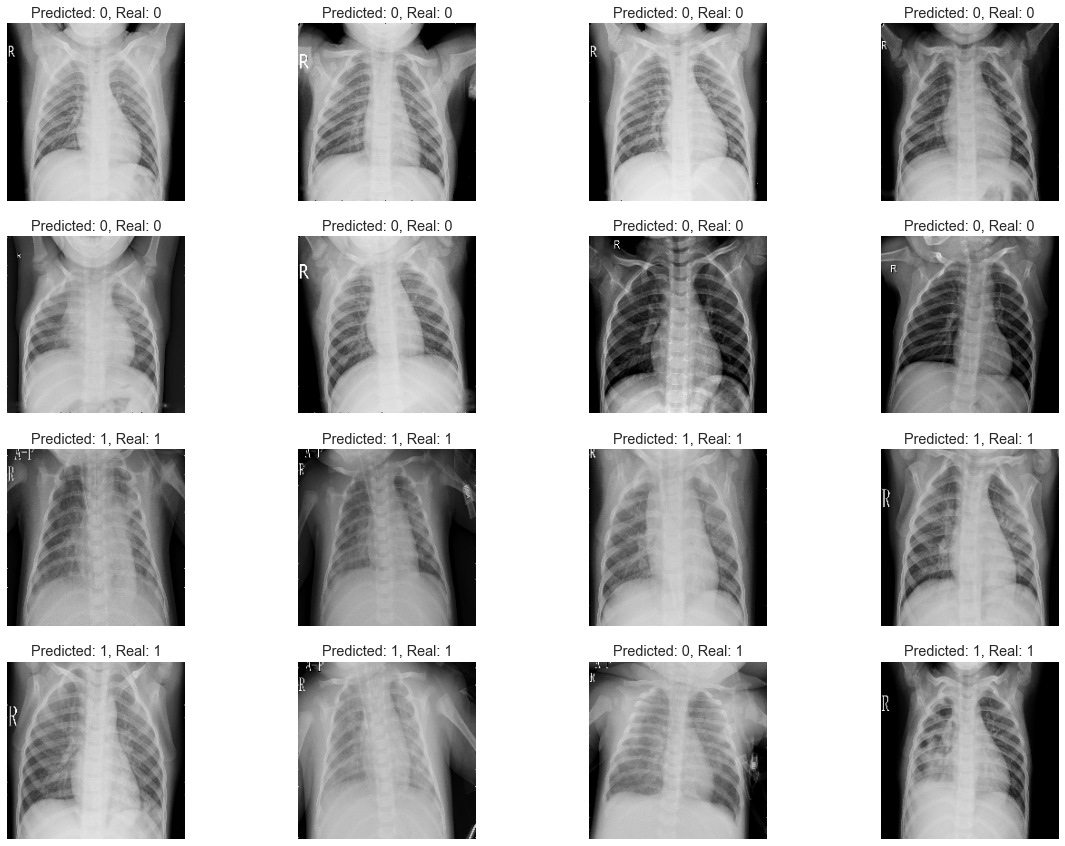

In [78]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))  